In [3]:
import pandas as pd
import numpy as np
import re #for regexs
import io #for chunk reading files
import os #For making directories
os.chdir("/Users/tesarylin/Box Sync/Data/Sherlock/2016Q3") 

In [4]:
ls

application.7z    moriartyprobe     t0
apppackages       screenon          t1
call              sms               userpresentprobe


# 1. Read ScreenOn

In [7]:
## shows an example below:

column = ['userid', 'uuid', 'screenon', 'timestamp']
DF = pd.read_csv("screenon", sep = "\t", names = column, header = None)

DF.head()

,userid,uuid,screenon,timestamp
0,aa2e99301a,1467331334563,True,2016-07-01 03:02:14.562
1,fdbca31c28,1467331452900,True,2016-07-01 03:04:12.893
2,fdbca31c28,1467331472739,False,2016-07-01 03:04:32.739
3,aa2e99301a,1467331486518,False,2016-07-01 03:04:46.515
4,bca57e81a1,1467331636423,True,2016-07-01 03:07:16.423


In [9]:
# Average number of interactions with phones, per user per day
DF.shape[0]/50/90  

147.31422222222224

In [13]:
# Print out a list of all users, which can be used to select a particular user from larger datasets if needed
print(len(DF['userid'].unique()))
DF['userid'].unique()  

48


array(['aa2e99301a', 'fdbca31c28', 'bca57e81a1', '1775bd8416',
       '8960d74df5', '6e200090ee', 'abd6f757b8', 'a4f29791af',
       '1a1a12314b', '2cd992fd5e', '94a2bee0bd', '0a50e09262',
       '5c1f751a99', '97dcbc4c4e', 'fe186dc437', '65f42fb278',
       '860550d355', '73e9841e35', '55153967c4', 'e0bf6beeb3',
       'fd2db8f0be', '55bd790216', '68a5ffab20', 'dd25a68e9e',
       '9f7c0cf3ba', 'ffaf2c6521', '8ef449026a', '56d7a3b146',
       'b298fa1895', '9c75d26567', '97bb95f55a', '831b42eaa1',
       '688dccef72', 'ec3b3592f1', '72edf5f08f', '909a83fa62',
       'cfdf8f8818', 'e306e8a7c9', 'd8d16595c6', 'b63c849327',
       'd35184bc22', 'f68d404dec', '3e9c54bce7', 'e22b9f3772',
       '6fec24656a', '5e9275b594', 'a582442b42', '5b76bedcac'], dtype=object)

In [79]:
# Example of selecting one user:
DF2 = DF[DF['userid']=='aa2e99301a']
DF2.shape

(20297, 4)

In [19]:
import matplotlib.pyplot as plt 
import seaborn
%matplotlib inline

In [22]:
# Count the number of screen on ==True for a given time interval: 

from datetime import datetime, timedelta
from itertools import groupby



In [27]:
# Convert unix timestamp to datetime object, so that we can extract different time and group the data accordingly
dt_obj = datetime.utcfromtimestamp(DF['uuid'][0]/1000) # this is UTC. 
print(dt_obj)

2016-07-01 00:02:14.563000


In [55]:
# Israel time is normally two hours plus UTC, but here it is 3 hours, as shown in the head observations
dt_obj = datetime.utcfromtimestamp(DF['uuid'][0]/1000)+ timedelta(minutes=180) 
print(dt_obj)

2016-07-01 03:02:14.563000


In [56]:
# Extract different components of time

print(dt_obj.year)
print(dt_obj.month)
print(dt_obj.day)
print(dt_obj.hour)
print(dt_obj.minute)

print(dt_obj.weekday()) #Monday is 0 and Sunday is 6

2016
7
1
3
2
4


In [63]:
# Alternatively we can get datetime from the string: 
# If we have string data, this is probably more robust as it directly reflects the influence in summer time
dt_obj = datetime.strptime(DF['timestamp'][0], "%Y-%m-%d %H:%M:%S.%f")
print(dt_obj)

2016-07-01 03:02:14.562000


In [64]:
DF2['time'] = DF2['timestamp'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f"))

/Users/tesarylin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [66]:
#del DF2['timestamp']

In [68]:
DF2.index = DF2['time']

# After indexing by datetime we can directly use resample() to group by time
DF2.resample('M').sum()  #frequency by month

,uuid,screenon
time,,
2016-07-31,9521921141953968,3250.0
2016-08-31,9922673990210574,3372.0
2016-09-30,10420751057245682,3528.0


In [74]:
#DF2.resample('D').sum()  #frequency by day
DF2.resample('W').sum()  #frequency by week
#DF2.resample('H').sum()  #frequency by hour

,uuid,screenon
time,,
2016-07-03,887825803823082,304.0
2016-07-10,2395555370287061,816.0
2016-07-17,2599147791069532,888.0
2016-07-24,2059579551328224,702.0
2016-07-31,1579812625446037,540.0
2016-08-07,973383709821078,331.0
2016-08-14,2463758008213030,837.0
2016-08-21,2313171180088345,787.0
2016-08-28,2620273244786411,890.0


It's apparent that above are all sequential. e.g. First week, second week, etc.

If instead we want to get a sense of weekday effect, we can use the following method:

In [84]:
DF2['hour'] = DF2['timestamp'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f").hour)
DF2['week'] = DF2['timestamp'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f").weekday())



/Users/tesarylin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/tesarylin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [109]:
#DF2['screenon'].groupby([DF2['week'], DF2['hour']]).sum()  # example of how to group by two columns

NameError: name 'key' is not defined

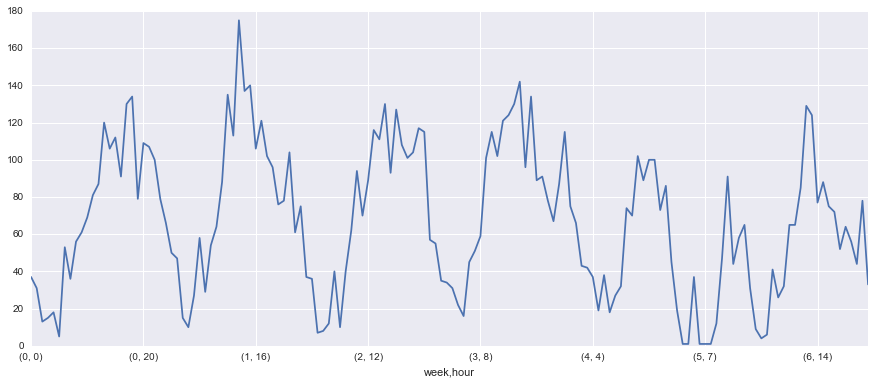

In [89]:
# And visualize:

fig, ax = plt.subplots(figsize = (15,6))
DF2['screenon'].groupby([DF2['week'], DF2['hour']]).sum().plot()

In [ ]:
# Or, to see each bar more clearly: 

fig, ax = plt.subplots(figsize = (15,6))
DF2['screenon'].groupby([DF2['week'], DF2['hour']]).sum().plot(kind = 'bar')
